# Electric Network Frequency Analysis
This Notebook is supposed to act as a step-by-step explanation of the
[Electric Network Frequency (ENF) Analysis script](https://github.com/Wuelle/enf_analysis) i made. 
I assume that the reader is familiar with the basic concept of a Fourier Transformation.
If you want to follow along, please run the downloader script and place an arbitrary audio sample in the `data/` directory.
Note that to keep this project fun, i tried to implement as much of the math as possible on my own.
Because of this, the notebook got quite large. Please make use of the table of contents below and skip around to the interesting parts.

<br><br>
*Supported by National Grid ESO Open Data*
## Table of Contents
* [Introduction](#Introduction)
* [Fourier Transformation](#Fourier-Transformation)
* [Short-time Fourier Transform](#Short-time-Fourier-Transform)

## Introduction
The european powergrid runs on alternating current, with a frequency of, in theory, exactly 50 Hertz. In practice however,
this value fluctuates due to changes in supply and demand. These Fluctuations are usually in the order of < 1Hz and do not affect everyday consumers at all.

Another thing to realize is that alternating current can leave <abbr title="Electric Network Frequency">ENF</abbr>-Artifacts in audio recordings.
The noise is know as the [Mains Hum](https://en.wikipedia.org/wiki/Mains_hum) and in its pure 50 Hz form, it
is too deep to be heard by a human ear. 

Luckily, the british [National Grid ESO](https://data.nationalgrideso.com) provides a 
[free dataset](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) of these frequency variations since January of 2019, which we can use to get the historical data. They record the frequency once per second, which is a lot more than i had initially hoped for.

If however, we extract this background noise and match it with the values from the dataset, we can exactly timestamp the recording.
This process has already been used in court to verify the authenticity of provided audio or to detect evidence of tampering.(because the <abbr title="Electric Network Frequency">ENF</abbr> would suddenly jump around)

Since i only have data from europe, my algorithm is only suitable for audio from europe. It should, however, be possible 
to adapt it to another frequency with only minimal changes. You can find your power grid frequency using the map below.
<img src=https://upload.wikimedia.org/wikipedia/commons/7/70/World_Map_of_Mains_Voltages_and_Frequencies%2C_Detailed.svg alt="Powergrid frequencies across the world" width=800>
*SomnusDe, Public domain, via Wikimedia Commons*

But exactly by how much does the grid frequency fluctuate? According to the [National Grids Mandatory Frequency Response Guide](https://www.nationalgrid.com/sites/default/files/documents/Mandatory%20Frequency%20Response%20Guide%20v1.1.pdf), the grid is considered

|   | unoperational | unstatuory |
| --- | --- | --- |
| below | 49.8Hz | 49.5Hz |
| above | 50.2Hz | 50.5Hz |

We will therefore only perform fourier transformations for the frequencies between 49.5Hz and 50.5Hz. Since the dataset
has a precision up to $\frac{1}{100}$ of a Hertz, it would be good to match that. We therefore need to perform Fourier transformations for $(50.5 - 49.5) \times 100 = 100$ frequencies.
The Nyquist Frequency, which i explain [here](#Nyquist-Frequency), tells us that to analyze frequencies up to 50.5Hz, we will need (at least) a sample rate of 101 samples per second. This is great because .wav files usually sit at around 48000 samples per second. By reducing the number of samples per second, we can greatly reduce the computations required.
If we want precision up to $\frac{1}{100}$ and a maximum of 50.5Hz, we will require $50.5 \times 100 = 5050$ samples.

### Excurse: Runtime Complexity
Like i mentioned above, we will be computing the fourier transformation for *specific* frequencies. 
If you are familiar with the algorithm, you will know that this is not the usual approach. In general, you throw a lot of samples at it and get a lot of frequencies back. To be precise, the number of frequencies is equal to the number of samples and each computations complexity is also proportional to the number of samples. This gives a runtime complexity of $O(n^2)$, which is really bad. But thats only for the naive DFT Algorithm, which is basically never used in practice. Optimizations,
like the popular [Cooley-Tukey Algorithm](![grafik.png](attachment:grafik.png)) can take the runtime down to $O(n log n)$.
These optimizations are generally referred to as 'Fast Fourier Transform', or FFT.

There is, however, one really important thing to realize about our use case:<br>
**We do not care about accurately deconstructing the original signal, we only care about the values around 50Hz.**<br>
The advantage of this is that we do not need to compute all $n$ frequencies. We can just compute a fixed number (like the 100 mentioned above) and discard the rest. This takes our runtime from $O(n^2)$ to $O(100 \times n)$, which might seem worse but its still $O(n)$, way better than any of the optimizations from FFT.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

## Fourier Transformation
The exact Algorithm is beyond the scope of this document, however the Youtube Channel [3b1b](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) provides an [excellent in-depth Explanation](https://www.youtube.com/watch?v=spUNpyF58BY).<br>
TLDR;<br>
A Fourier Transformation is a process by which the underlying frequencies of a noisy signal can be extracted.<br>

The [data](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) has a resolution of one sample per second. So there is no need to calculate anything more precise than that since we would just be overfitting the data anyway.

In [10]:
from scipy.io import wavfile
from scipy.signal import resample

# if you are using your own data, make sure its mono
samplerate_, data_ = wavfile.read("ENF-WHU-Dataset/ENF-WHU-Dataset/H1/002.wav")

# the maximum frequency we want to analyze
max_f = 50.5
# the precision with which we wish to analyze
precision = 1/100
# the number of samples per second
samplerate = np.ceil(2 * max_f)
# the number of samples per fft
window_size = int(max_f / precision)

data = resample(data_, int(data_.size * (samplerate / samplerate_)))

Just slicing the wave file to the size of a window is insufficient, since it artificially creates edges at the start and end of the window. To avoid this, we multiply the window by a half cosine function to ensure a smooth transition. (This is called a [Hanning Window](https://numpy.org/doc/stable/reference/generated/numpy.hanning.html))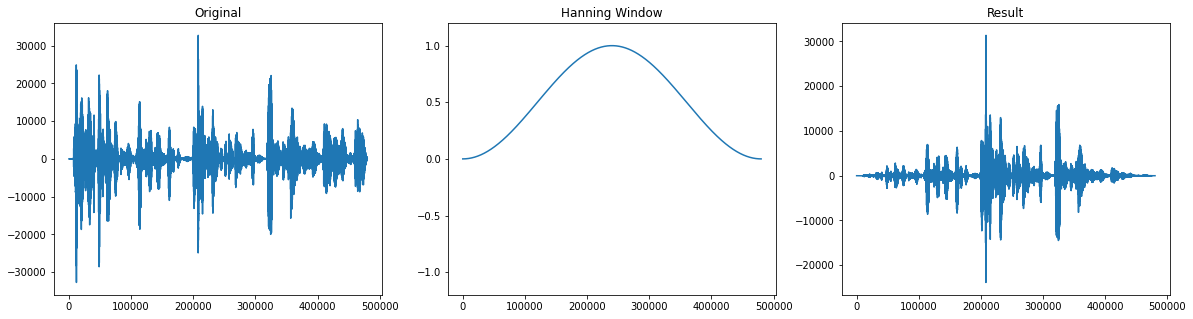

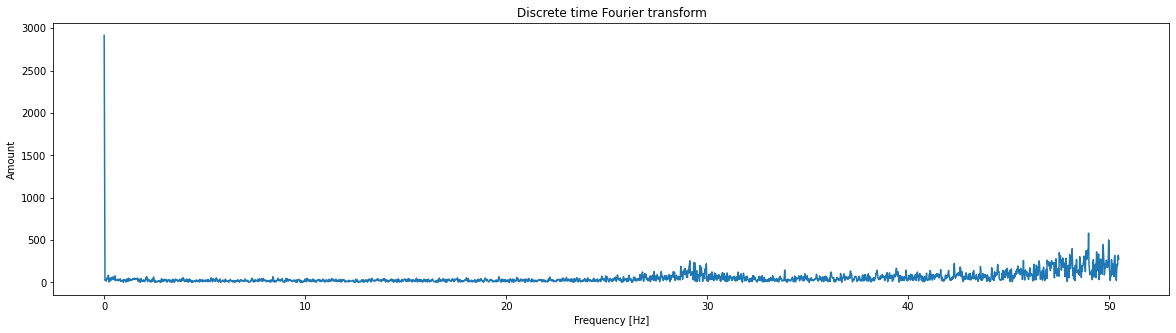

Main frequency at 0.0 Hz


In [11]:
window = data[:window_size]
fourier = np.abs(np.fft.fft(window * np.hanning(window_size)))[:window_size//2]
frequencies = np.fft.fftfreq(2 * fourier.size, d=1/samplerate)[:window_size//2]

plt.plot(frequencies, fourier)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amount")
plt.title("Discrete time Fourier transform")
plt.show()
print("Main frequency at", np.argmax(fourier) * samplerate/window_size, "Hz")

## Improving DFT
It has been shown that the accuracy of the Discrete-Time Fourier Transform increases when operating on the first-order derivative of the signal.

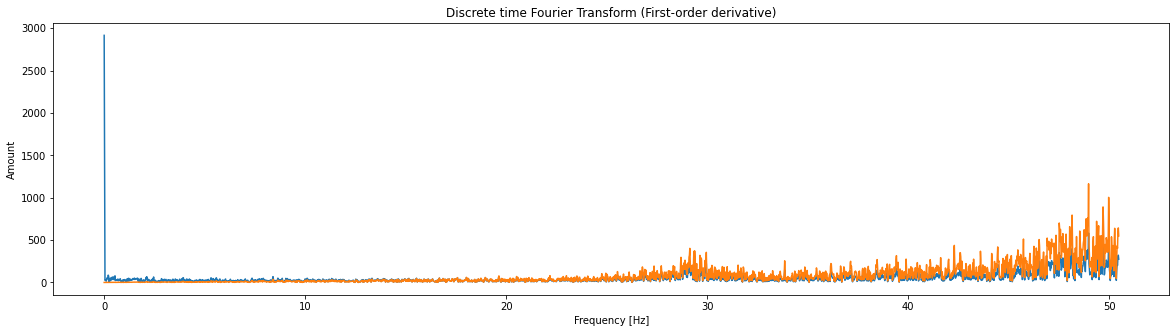

Main frequency at 0.0 Hz


In [16]:
window_raw = data[:window_size]

window = window_raw * np.hanning(window_size)
window_derivative = np.diff(window_raw, prepend=0) * np.hanning(window_size)

fourier = np.abs(np.fft.fft(window))[:window_size//2]
fourier_derivative = np.abs(np.fft.fft(window_derivative))[:window_size//2]

frequencies = np.fft.fftfreq(2 * fourier.size, d=1/samplerate)[:window_size//2]

plt.plot(frequencies, fourier)
plt.plot(frequencies, fourier_derivative)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amount")
plt.title("Discrete time Fourier Transform (First-order derivative)")
plt.show()

k_peak = np.argmax(fourier)
print("Main frequency at", np.argmax(fourier) * samplerate/window_size, "Hz")

In [14]:
print(window_size, samplerate)

5050 101.0


We can clearly see the spike at approximately 50Hz. This is the noise created by the electric network that we are looking
for. If, at this point, you do not see a spike, the audio does not contain that noise and it cannot be timestamped using the
algorithm.

### Nyquist Frequency
The mathematical nature of the Fourier Transformation imposes a limit on the frequency that can meaningfully be analyzed.
This limit is called the [Nyquist Frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) and its always equal to the number of samples divided by two.
Luckily we need not concern ourselves with this, since we are interested in the frequency activity between 49.5Hz and 50.5Hz, 
any window with more than 100 samples (which at a sample rate of 48000 samples per second would be 1/480th of a second long) will suffice.

## Short-time Fourier Transform
This, however, is just a Fourier transform of the first second.<br>
Since we are interested in how the frequency varies over time, we need to compare multiple transformations against each other. This process is known as a [Short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)<br>
A samplerate of 48000 means that to get one Fourier transform per second, we need to offset our sliding window by 48000 samples each time. Since we expect a frequency of around 50 Hertz, a window size of 5 seconds, amounting to ~250 cycles should be more than sufficient.<br>
The next question is: How far should the sliding window shift after each iteration? This will determine the resolution of our final frequency graph. Since the [data](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) only lists one data point per second, calculating anything more than that would just be overfitting the data. If you want to use this with your own dataset, you might want to adjust this value.

In [159]:
window_length = 10 # length of the window in seconds
window_size = samplerate * window_length # number of samples per window
n_windows = 1 # total number of windows
offset = 1024 # offset of each window
f_min = 49.5
f_max = 50.5
num_f = 100
d_f = (f_max - f_min) / num_f
result = np.empty((n_windows, num_f))

In [ ]:
%%time
for ix in range(n_windows):
    window = data[ix * offset:ix * offset + window_size]
    window = window * np.hanning(window_size)
    fourier = np.abs(dft(window, d_f, np.linspace(f_min, f_max, num_f)))
    result[ix] = fourier[:num_f]
result = 20 * np.log10(result)

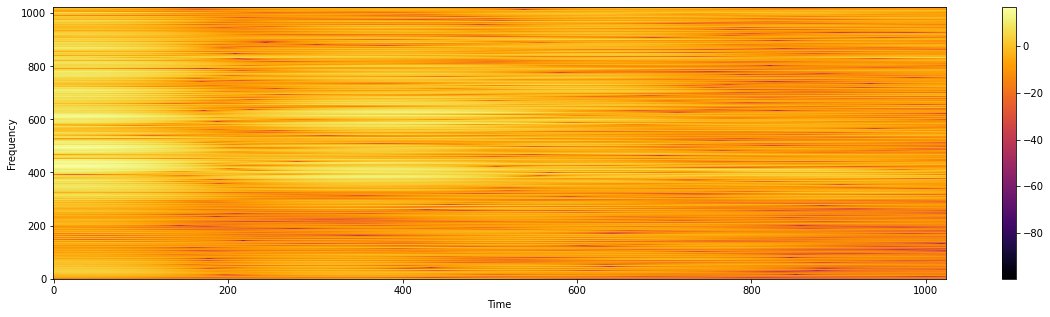

In [62]:
plt.imshow(result.transpose(), cmap="inferno", interpolation="nearest", aspect="auto", origin="lower")
plt.colorbar()
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

Now, is this just a slower, more complicated version of `plt.specgram`?<br>
Yes. But i feel like its worth understanding whats going on behind the scenes.

We need to scale the values to the dB scale, which is logarithmic.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_14044/3113077252.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(f, t, 10 * np.log10(sxx), shading="gouraud", cmap="inferno")


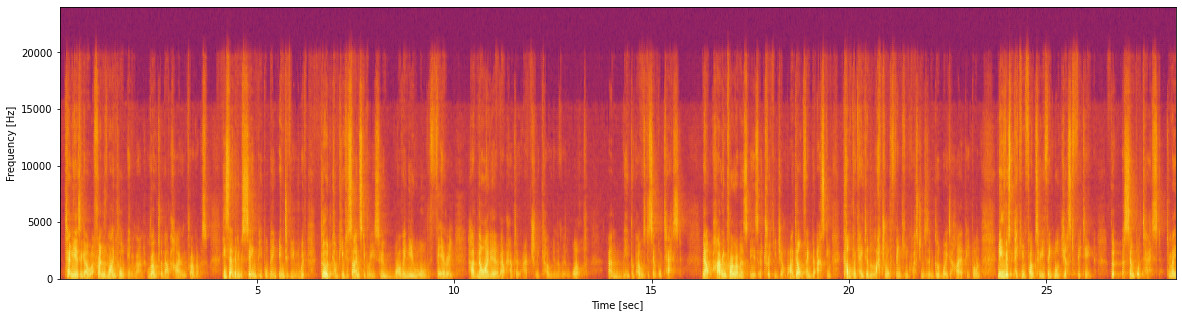

In [86]:
from scipy import signal
t, f, sxx = signal.spectrogram(data, fs=samplerate)

plt.pcolormesh(f, t, 10 * np.log10(sxx), shading="gouraud", cmap="inferno")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.show()

In [17]:
x = np.arange(100)
resampled = resample(x, 50)
print(resampled)

[ 24.5         -4.32051595   7.25837904   3.94462752   9.41837035
   8.97634778  12.75395463  13.44309098  16.40570148  17.71479383
  20.18624914  21.89705691  24.03133426  26.03133426  27.91295285
  30.13727334  31.81687264  34.22547429  35.73499974  38.3022611
  39.66228325  42.37175639  43.59528288  46.43689843  47.53142627
  50.5         51.46857373  54.56310157  55.40471712  58.62824361
  59.33771675  62.6977389   63.26500026  66.77452571  67.18312736
  70.86272666  71.08704715  74.96866574  74.96866574  79.10294309
  78.81375086  83.28520617  82.59429852  87.55690902  86.24604537
  92.02365222  89.58162965  97.05537248  91.74162096 105.32051595]


In [18]:
x = np.array([2, 3, 4, 1])
print(np.fft.fft(x))
print(np.fft.d)

[10.+0.j -2.-2.j  2.+0.j -2.+2.j]
